In [1]:
import json

import matplotlib.pylab as plt
import numpy as np

config_file = "power_scans.json"

In [2]:
def load_file(
    fname, power_x_axis_choices=("pm_powers", "pm_powers_after", "power_wheel_position")
):
    import h5py

    with h5py.File(fname, "r") as h5file:
        if "sample" in h5file["app/settings"].attrs.keys():
            sample = h5file["app/settings"].attrs["sample"]
        if "measurement/power_scan_df" in h5file:
            H = h5file["measurement/power_scan_df"]
        else:
            H = h5file["measurement/power_scan"]

        # # Provide wls and spectra
        # wls has shape (N_wls,) [dim=1]
        # spectra has shape (Np, N_channels, N_wls).
        #    E.g. with Np=21 and N_wls=512:
        wls = np.arange(512)
        spectra = 0.5 * np.arange(512 * 21 * 1).reshape((21, 1, 512))
        # If present override acq_times_array which will be used
        # to normalize to counts per second:
        acq_times_array = [None]

        aquisition_type = (
            "No data found"  # some info text that will be shown in the title
        )

        if "integrated_spectra" in H:
            for k in H.keys():
                if "acq_times_array" in k:
                    acq_times_array = H[k][:]
            wls = H["wls"][:]
            spectra = H["spectra"][:].reshape(-1, 1, len(wls))
            aquisition_type = "Spectrum"

        for harp in ["picoharp", "hydraharp"]:
            if "{}_histograms".format(harp) in H:
                histograms = H["{}_histograms".format(harp)][:]
                acq_times_array = H["{}_elapsed_time".format(harp)][:]
                wls = H["{}_time_array".format(harp)][:]
                if np.ndim(histograms) == 2:
                    histograms = histograms.reshape(-1, 1, len(wls))
                spectra = histograms
                aquisition_type = harp

        if "apd_count_rates" in H:
            apd_count_rates = H["apd_count_rates"][:]
            spectra = apd_count_rates.reshape((-1, 1, 1))
            aquisition_type = "APD"

        if "thorlabs_powermeter_2_powers" in H:
            powers_y = H["thorlabs_powermeter_2_powers"][:]
            spectra = powers_y.reshape((-1, 1, 1))
            aquisition_type = "power_meter_2"

        Np = spectra.shape[0]
        if np.any(acq_times_array == None):
            spectra = (1.0 * spectra.T / acq_times_array).T
        else:
            spectra = 1.0 * spectra  # ensure floats

        # if scan was no completed the power arrays will be chopped
        # get power arrays
        power_arrays = {}
        for key in power_x_axis_choices:
            try:
                power_arrays.update({key: H[key][:Np]})
            except:
                pass

        if Np != len(H["pm_powers"][:]):
            aquisition_type = "[INTERRUPTED Scan] " + aquisition_type

    return spectra, power_arrays, aquisition_type, sample


def get_dependence_data(power_array, spectra, signal_mask, background_mask, params):
    channel = params["channel"]
    binning = params["power_binning"]
    conversion_factor = params["conversion_factor"]

    if params["bg_selector"]["activated"]:
        bg = spectra[:, channel, background_mask].mean()
    else:
        bg = 0

    data = spectra[:, channel, signal_mask]
    if binning > 1:
        Np, ns = data.shape
        data = (
            data[: (Np // binning) * binning, :].reshape(-1, binning, ns).mean(axis=1)
        )
    y = data.sum(axis=-1) - bg

    x = power_array
    if binning > 1:
        x = x[: (len(x) // binning) * binning].reshape(-1, binning).mean(-1)

    x = x * conversion_factor

    # return x, y
    # only positive values
    mask = (y > 0) * (x > 0)
    return x[mask], y[mask]


def make_mask(params, N, selector="bg_selector"):
    if params[selector]["activated"]:

        if params[selector]["mode"] == "mask":
            return params[selector]["mask"]

            # rgn = params[selector]["region"]
            # return wls >= min(rgn) * wls <= max(rgn)
        else:
            mask = np.zeros(N).astype(bool)
            s = slice(
                params[selector]["start"],
                params[selector]["stop"],
                params[selector]["step"],
            )
            mask[s] = True
            return mask
    else:
        return np.ones(N, dtype=bool)

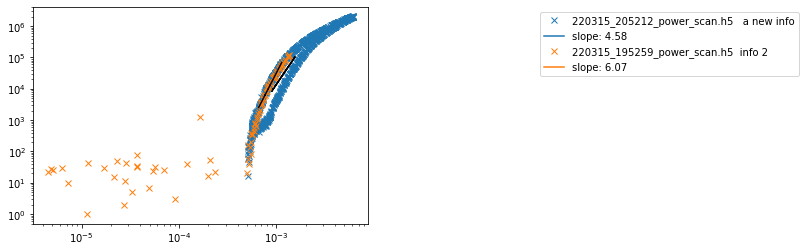

In [3]:
with open(config_file, "r") as f:
    params_collection = json.load(f)


slopes = []

for fname, params in params_collection.items():
    if not params["ignore"]:
        spectra, power_arrays, aquisition_type, sample = load_file(fname)
        power_array = power_arrays[params["power_x_axis"]]
        x, y = get_dependence_data(
            power_array,
            spectra,
            make_mask(params, spectra.shape[-1], selector="signal_selector"),
            make_mask(params, spectra.shape[-1], selector="bg_selector"),
            params,
        )
        
        # Fit
        power_mask = make_mask(params["plot_n_fit"], len(y), selector="data_selector")
        x_, y_ = np.log10(x[power_mask]), np.log10(y[power_mask])
        coefs = np.polynomial.polynomial.polyfit(x_, y_, 1)
        fit = 10 ** np.polynomial.polynomial.polyval(x_, coefs)
        slopes.append(coefs[1])

        
        # plot
        p = plt.loglog(x, y, "x", label=f"{fname} {sample} {params['info']}")
        plt.loglog(
            x[power_mask],
            fit,
            "-",
            color=p[0].get_color(),
            label=f"slope: {coefs[1]:1.2f}",
        )
        plt.loglog(
            x[power_mask], fit, "-", color="k",
        )

    plt.legend(bbox_to_anchor=(1.5, 1, 0.2, 0.0))